# ISCAS Paper Work
See `ifat.py` for synaptic connetvitiy plots

In [1]:
from brian2 import *
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def visualize_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

In [3]:
def calc_weight(M, alpha, mu, sigma):
    output = zeros((M,M))
    for i in np.arange(M):
        for j in np.arange(M):
            output[i,j] = exp(cos((2*pi*i/M) - (2*pi*j/M) - mu)/sigma**2)
    output = output * (alpha/np.max(output))
    output = 5.0 * fF * np.around(output/(5.0*fF))
    return output

In [4]:
MODE = 'adaptive'
PARASITICS = True

In [5]:
# Define various equations

if MODE == 'adaptive':
    neuron_eq = '''
        dVm/dt = ((glm + gpar) / Cm) * (Vm_r - Vm)  : volt
        dVt/dt = ((glt + gpar) / Ct) * (Vt_r - Vt)  : volt
        
        # dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt
        # dVt/dt = (glt / Ct) * (Vt_r - Vt) : volt

        glm = flm * Cl                              : siemens
        glt = flt * Cl                              : siemens
        gpar = par_ctrl / par_leak_time * Cm : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
        Vt = Vt * (Vt > Vm) + Vt_r * (Vt <= Vm)
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
        Vt += (Cst/Ct) * (Vm_old - Vm_r)
    '''
else:
    neuron_eq = '''
        dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt

        glm = flm * Cl                    : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
    '''

# Synapse equation is the same for both modes!
syn_eq = '''
    Vsyn = (W/Cm)*(Em - Vm) : volt
    Em                      : volt
    W                       : farad
'''

In [6]:
# IFAT specific definitions
fF = 0.001 * pF
Vdd = 5 * volt
Cm = Ct = 440 * fF
Cl = 2 * fF

W_vals  = np.array([5, 10, 20, 40, 80]) * fF
Em_vals = np.array([0, 1/3, 2/3, 1]) * Vdd

par_ctrl = True
par_ctrl = float(PARASITICS)
par_leak_time = 12.5 * ms

In [7]:
# Model parameters
Vm_r = 1 * volt
flm  = 0 * kHz
Csm  = W_vals[0]

Vt_r = 3.5 * volt
flt  = 0 * MHz
Cst  = 0 * fF

M = 64

In [8]:
# Connectivity specifics
alpha = sum(W_vals)
mu1 = 0
mu2 = 2*pi/3
mu3 = pi
sigma = 36 * pi/180

In [9]:
start_scope()

blair_exc = NeuronGroup(M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
blair_exc.Vt = Vt_r
blair_exc.Vm = Vm_r

blair_inh = NeuronGroup(M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
blair_inh.Vt = Vt_r
blair_inh.Vm = Vm_r

In [10]:
exc2inh = Synapses(blair_exc, blair_inh, syn_eq, on_pre=presyn_eq)
exc2inh.connect()
exc2inh.Em = Em_vals[3]
exc2inh.W = calc_weight(M,alpha,mu1,sigma).flatten()

inh2exc = Synapses(blair_inh, blair_exc, syn_eq, on_pre=presyn_eq)
inh2exc.connect()
inh2exc.Em = Em_vals[0]
inh2exc.W  = calc_weight(M,alpha,mu2,sigma).flatten()

inh2inh = Synapses(blair_inh, blair_inh, syn_eq, on_pre=presyn_eq)
inh2inh.connect()
inh2inh.Em = Em_vals[0]
inh2inh.W = calc_weight(M,alpha,mu1,sigma).flatten()

In [11]:
PoisIn = PoissonGroup(M,rates=2.0*kHz)
p2exc = Synapses(PoisIn, blair_exc, syn_eq, on_pre=presyn_eq)
p2exc.connect('j==i')
p2exc.Em = Em_vals[3]
p2exc.W = W_vals[2] + W_vals[0]# + W_vals[0]

In [12]:
i_spmon = SpikeMonitor(blair_inh)
e_spmon = SpikeMonitor(blair_exc)
e_vmon = StateMonitor(blair_exc, 'Vm', record=True)
erate00 = PopulationRateMonitor(blair_exc[:1])
erate15 = PopulationRateMonitor(blair_exc[15:16])
erate31 = PopulationRateMonitor(blair_exc[31:32])
erate47 = PopulationRateMonitor(blair_exc[47:48])
#irate = PopulationRateMonitor(blair_inh[:1])

In [13]:
store()
poissonRates = arange(2.0,4.0,0.1)*kHz

In [14]:
#rateOuts = zeros((4,20))
eRates00 = []; eRates00b = []; eRates00c = []
eRates15 = []; eRates15b = []; eRates15c = []
eRates31 = []; eRates31b = []; eRates31c = []
eRates47 = []; eRates47b = []; eRates47c = []

In [15]:
BrianLogger.suppress_hierarchy('brian2.codegen.generators.base')
for thing in range(3):
    for poissonRate in poissonRates:
        restore()
        PoisIn.rates = poissonRate
        print(poissonRate)
        run(8*second,report='text')
        if thing == 0:
            eRates00.append(erate00.smooth_rate(width=100*ms))
            eRates15.append(erate15.smooth_rate(width=100*ms))
            eRates31.append(erate31.smooth_rate(width=100*ms))
            eRates47.append(erate47.smooth_rate(width=100*ms))
        elif thing == 1:
            eRates00b.append(erate00.smooth_rate(width=100*ms))
            eRates15b.append(erate15.smooth_rate(width=100*ms))
            eRates31b.append(erate31.smooth_rate(width=100*ms))
            eRates47b.append(erate47.smooth_rate(width=100*ms))
        else:
            eRates00c.append(erate00.smooth_rate(width=100*ms))
            eRates15c.append(erate15.smooth_rate(width=100*ms))
            eRates31c.append(erate31.smooth_rate(width=100*ms))
            eRates47c.append(erate47.smooth_rate(width=100*ms))

2. kHz
Starting simulation at t=0. s for a duration of 8. s
8.0 (100%) simulated in 9s
2.1 kHz
Starting simulation at t=0. s for a duration of 8. s
8.0 (100%) simulated in 9s
2.2 kHz
Starting simulation at t=0. s for a duration of 8. s
8.0 (100%) simulated in 9s
2.3 kHz
Starting simulation at t=0. s for a duration of 8. s
8.0 (100%) simulated in 9s
2.4 kHz
Starting simulation at t=0. s for a duration of 8. s
8.0 (100%) simulated in 9s
2.5 kHz
Starting simulation at t=0. s for a duration of 8. s
8.0 (100%) simulated in 9s
2.6 kHz
Starting simulation at t=0. s for a duration of 8. s
8.0 (100%) simulated in 9s
2.7 kHz
Starting simulation at t=0. s for a duration of 8. s
8.0 (100%) simulated in 9s
2.8 kHz
Starting simulation at t=0. s for a duration of 8. s
8.0 (100%) simulated in 9s
2.9 kHz
Starting simulation at t=0. s for a duration of 8. s
8.0 (100%) simulated in 9s
3. kHz
Starting simulation at t=0. s for a duration of 8. s
8.0 (100%) simulated in 9s
3.1 kHz
Starting simulation at t=0

(2, 2.1)

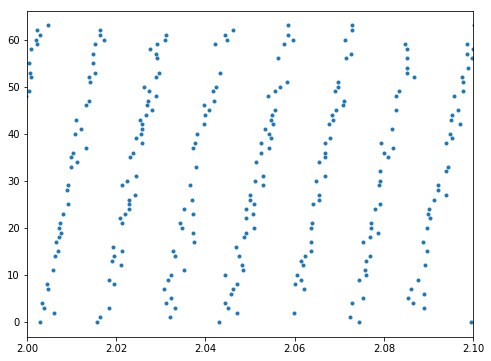

In [16]:
figure(figsize=(8,6))
plot(e_spmon.t/second, e_spmon.i,'.'); xlim([2,2.1])

(2, 6)

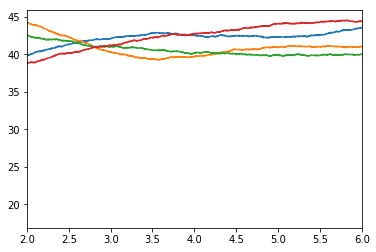

In [17]:
rateWidth = 1000 * ms
plot(erate00.t/second, erate00.smooth_rate(width=rateWidth)/Hz,
     erate15.t/second, erate15.smooth_rate(width=rateWidth)/Hz,
     erate31.t/second, erate31.smooth_rate(width=rateWidth)/Hz,
     erate47.t/second, erate47.smooth_rate(width=rateWidth)/Hz)
xlim([2,6])

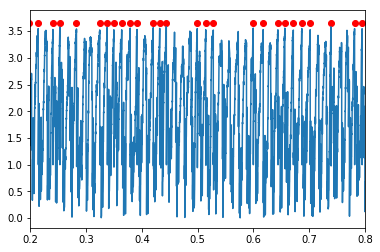

In [18]:
idx = 34
plot(e_vmon.t, e_vmon.Vm[idx]); xlim([0.2,0.8])
scatter(e_spmon.t[e_spmon.i==idx],3.65*ones(len(e_spmon.t[e_spmon.i==idx])),color='r')

In [19]:
smooth_width = 1000*ms

sig_shape = shape(eRates00)
avgRate = zeros(sig_shape)
avgRateB = zeros(sig_shape)
avgRateC = zeros(sig_shape)

for i in range(sig_shape[0]):
    avgRate[i,:]  = eRates00[i]#.smooth_rate(width=smooth_width)
    avgRate[i,:] += eRates15[i]#.smooth_rate(width=smooth_width)
    avgRate[i,:] += eRates31[i]#.smooth_rate(width=smooth_width)
    avgRate[i,:] += eRates47[i]#.smooth_rate(width=smooth_width)
    avgRate[i,:] = avgRate[i,:]/4
    avgRateB[i,:]  = eRates00b[i]#.smooth_rate(width=smooth_width)
    avgRateB[i,:] += eRates15b[i]#.smooth_rate(width=smooth_width)
    avgRateB[i,:] += eRates31b[i]#.smooth_rate(width=smooth_width)
    avgRateB[i,:] += eRates47b[i]#.smooth_rate(width=smooth_width)
    avgRateB[i,:] = avgRateB[i,:]/4
    avgRateC[i,:]  = eRates00c[i]#.smooth_rate(width=smooth_width)
    avgRateC[i,:] += eRates15c[i]#.smooth_rate(width=smooth_width)
    avgRateC[i,:] += eRates31c[i]#.smooth_rate(width=smooth_width)
    avgRateC[i,:] += eRates47c[i]#.smooth_rate(width=smooth_width)
    avgRateC[i,:] = avgRateC[i,:]/4

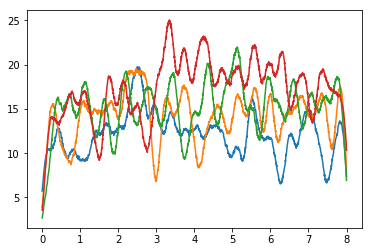

In [20]:
plot(erate00.t/second, avgRateB[0,:]/Hz,
     erate00.t/second, avgRateB[1,:]/Hz,
     erate00.t/second, avgRateB[2,:]/Hz,
     erate00.t/second, avgRateB[3,:]/Hz)

(1.5, 6.5)

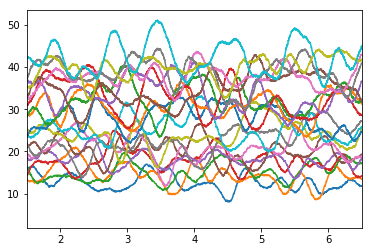

In [21]:
for i in range(sig_shape[0]):    
    plot(erate00.t/second, avgRate[i,:]/Hz)
xlim([1.5,6.5])

In [24]:
cut_start = 20000; cut_stop = 60000
meanRates = np.mean(avgRate[:,cut_start:cut_stop], axis=1)
stdRates  = np.std(avgRate[:,cut_start:cut_stop], axis=1)
meanRatesB = np.mean(avgRateB[:,cut_start:cut_stop], axis=1)
stdRatesB  = np.std(avgRateB[:,cut_start:cut_stop], axis=1)
meanRatesC = np.mean(avgRateC[:,cut_start:cut_stop], axis=1)
stdRatesC  = np.std(avgRateC[:,cut_start:cut_stop], axis=1)

<Container object of 3 artists>

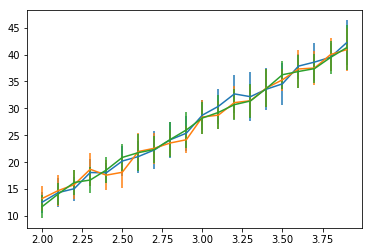

In [25]:
ax = gca()
ax.errorbar(poissonRates/1000, meanRates, yerr=stdRates)
ax.errorbar(poissonRates/1000, meanRatesB, yerr=stdRatesB)
ax.errorbar(poissonRates/1000, meanRatesC, yerr=stdRatesC)

In [26]:
totAvgRate = (avgRate + avgRateB + avgRateC)/3.0
meanRatesTotal = np.mean(totAvgRate[:,cut_start:cut_stop], axis=1)
stdRatesTotal = np.std(totAvgRate[:,cut_start:cut_stop], axis=1)

<Container object of 3 artists>

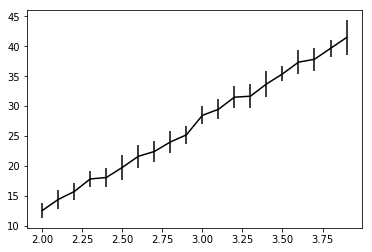

In [31]:
ax = gca()
ax.errorbar(poissonRates/1000, meanRatesTotal, yerr=stdRatesTotal, color='k')